<a href="https://colab.research.google.com/github/sinnli/project_deep_learning/blob/master/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Instrument Recognition - Final Project Intro to Deep Learning**
---
Submitted by:

**Ohad Levy** ID:318732880

**Liel Sinn** ID:209195155

February 2023



#**1.1. Introduction**


The project we chose is about recognizing the instruments playing in a piece of music.

Our work came from the common background we share together - our love to music.

The capability of listening to a song, and extracting the list of instruments playing in each part of it, seems imposible to ordinary people like us, but sounded like a suitable mission for a neural network to deal with.

travelling in the internet led us to the dataset called MUSICNET, a dataset containing 330 songs of classical music, each one of them is accompanied by a CSV file indicating precisely what note is played in every moment in the song, and what instrument is playing it. One might notice that in every moment in the song, a few instruments can play together, ***making our task a multilabeling task***.

In out project we tried to tackle this task with the tools we learned in class and practiced in our home assignments, integrating some knowledge shared be the state of the art works, trying to achieve the highest accuracy we possibly could.

Chapter 1 presenting the work related to the analysis we had in the time domain.

After analyzing the results we got with various architectures in the, we tried to convert our music to the frequency domain, in then try to analyze it with a neural network. this work is depicted in chapter 2.


In chapter 3 we conclude our work, and discuss about some future improvments we might implement during spring break (since we want to outperform the state of the art).

# **1.2. Preprocessing**

### **Imports:**

In [ ]:
from google.colab import drive
import scipy.io.wavfile
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.io import wavfile
import os
import librosa
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import pandas as pd
import random
import pickle

drive.mount('/content/gdrive')
models_path = '/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/models/'
variables_path = '/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/variables'
data_path = '/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/musicnet'
proj_path = '/content/gdrive/MyDrive/Intro_to_Deep_Learning/project'
train_path = '/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/musicnet/train_data'
train_labels_path = '/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/musicnet/train_labels'
test_path = '/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/musicnet/test_data'
test_labels_path = '/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/musicnet/test_labels'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **Defining the functions:**

Now, we are going to define some functions that help us import the data, and preprocess it before training part.

The problem we faced here is defining the problem:

We wanted to identify what instrument is playing in each piece of music; but we didn't define how long is enough to be a piece of music.

Suppose we have 330 song, we dont have enough data samples to train our model, and on the other hand we want to be more precise in our prediction.

So, we take every 5 seconds of a song, (in the rest of the work, each piece of 5 secong is called *short*), and couple it with its according labels, and save it in a tuple.

These operations are done using the functions detailed here:

In [ ]:
def loadTrainData(start, end, files, path, deleted_files= None):
  """
  Loading a certain part of the train data,
  by iterating over the files in train_files and save them in a variable named train_data.
  """
  Data = [0]*(int(end)-int(start))
  i = 0
  loaded_files_list = []
  for j, file in enumerate(files):
    if (j>=start and j<end):
      if int(file[:4]) not in deleted_files:
        data, samplerate = librosa.load(path +'/'+ file)
        Data[i] = (samplerate,data)
        loaded_files_list.append(files[j])
        i+=1
  return Data[:i] , loaded_files_list


def divideToShorts(train_data):
  """
  Taking each piece given by samples in the time domain
  and dividing it to shorts
  """
  train_data_5sec = [0] * len(train_data)
  j = 0
  for i,file in enumerate(train_data):
      short_pieces = librosa.util.frame(file[1], frame_length=5*train_data[i][0], hop_length=5*train_data[i][0])
      train_data_5sec[i] = short_pieces
      j+=1

  return train_data_5sec

def extract_labels(labels_path,file_names):
  # comparing the labels and the train files:
  labels_to_extract = [f.replace(".wav",".csv") for f in file_names]
  labels = [f for f in os.listdir(labels_path) if f in labels_to_extract]
  for file in labels:
    df = pd.read_csv(os.path.join(labels_path, file))
    df["start_seconds"] = df["start_time"]/44100
    df["end_seconds"] = df["end_time"]/44100
    df.to_csv(os.path.join(labels_path, file),index=False)

  missing_files =set(labels_to_extract) - set(labels)
  if missing_files:
      print("Missing files in train_files:", missing_files)
      return None
  else:
      pass
  return labels


def create_dict(train_labels_path, train_labels):
    """
    for every song, creates a dictionary indicating what instruments are playing in every short.
    saves all dictionaries in a list.
    """
    list_of_dicts = []
    for k, file in enumerate(train_labels):
        df = pd.read_csv(os.path.join(train_labels_path, file))
        last_time = df["end_seconds"].tail(1).values[0]
        time_range_dict = {}
        for i in range(0, int(np.floor(last_time-1)), 5):
              start_time = i
              end_time = i + 5
              # Get the rows where start_seconds or end_seconds are between the current time span
              rows = df[(df["start_seconds"] >= start_time) & (df["start_seconds"] < end_time) | (df["end_seconds"] > start_time) & (df["end_seconds"] <= end_time)]
              # Get the set of instruments in the current time span
              instruments = set(rows["instrument"])
              # Add the current time span and instruments to the dictionary
              time_range_dict[f"{start_time}-{end_time}"] = instruments
        list_of_dicts.append(time_range_dict)
    return list_of_dicts

def create_one_hot(dictionaries):
    """
    Translating te labels from [0,1,...,127]
    to a 128-vector that has 1's in the corresponding index
    """
    list_of_one_hot_vectors = []
    for dicti in dictionaries:
        one_hot_vectors = {}
        for key, instruments in dicti.items():
            one_hot = np.zeros(128)
            # Set the index of the instruments to 1 in the vector
            one_hot[list(instruments)] = 1
            one_hot_vectors[key] = one_hot
        list_of_one_hot_vectors.append(one_hot_vectors)
    return list_of_one_hot_vectors


def create_tuples(train_data_5sec ,list_one_hot_vecs):
    train_data_tuples = []
    for song,one_hots in zip(train_data_5sec,list_one_hot_vecs):
        min_len = min(song.shape[1], len(one_hots))
        song_trans = np.array(song).T.tolist()
        song_trans = song_trans[0:min_len]
        for short, one_hot in zip(song_trans, one_hots):
            train_data_tuples.append((torch.tensor(short), torch.tensor(one_hots[one_hot])))
    return train_data_tuples



def divide_and_batch_tensor(train_data_tuples, batch_size, validation_percentage=0.1):
    """
    takes all the tuples of (short,onehot-vector), shuffles them, and devides to batches.
    """
    random.shuffle(train_data_tuples)
    validation_split = int(validation_percentage * len(train_data_tuples))
    validation_tuples = train_data_tuples[:validation_split]
    train_tuples = train_data_tuples

    def get_batch(batch_data):
        inputs = [x[0] for x in batch_data]
        labels = [x[1] for x in batch_data]
        return torch.stack(inputs), torch.stack(labels)

    batches = [get_batch(train_data_tuples[i:i + batch_size]) for i in range(0, len(train_data_tuples), batch_size)]
    validation_batch = [get_batch(validation_tuples)]

    return batches, validation_batch

def reduce_to_11(batch, indices = [1,7,41,42,43,44,61,69,71,72,74]):
    """
    since we later found out we have only 11 instruments playing in our data, wrote a function the shrinks the labels of every batch
    from a 128-long vector to a 11-long vector, without losing any information.
    """
    inputs, targets = batch
    reduced_targets = torch.zeros((targets.shape[0],len(indices)))
    reduced_batch = (inputs, reduced_targets)

    for j,target in enumerate(targets):
        reduced_target = torch.zeros(len(indices))
        reduced_target = target[indices]
        reduced_batch[1][j] = reduced_target

    return reduced_batch


def translate(label):
  """
  translates the output back to the name of the instrument
  """
  #building pairs
  indices = [1,7,41,42,43,44,61,69,71,72,74]
  instruments = [ "Acoustic Grand Piano","Harpsichord","Violin","Viola", "Cello", "Contrabass",
               "French Horn","Oboe","Bassoon","Clarinet","Flute"]
  pairs = []
  for i in range(min(len(indices), len(instruments))):
    pairs.append((indices[i], instruments[i]))
  instru = []
  label = label.cpu()
  label = label.detach().numpy()
  nonzero_indices = np.where((np.abs(label) >= 0.5) & (np.abs(label) <= 1.45))
  nonzero_indices = torch.tensor(nonzero_indices)
  for i in range(len(nonzero_indices)):
    instru.append(pairs[nonzero_indices[i][0]][1])

  return instru


# Defining list of files for train and test files:
train_files = [f for f in os.listdir(train_path) if f.endswith('.wav')]
train_files.sort()
test_files = [f for f in os.listdir(test_path) if f.endswith('.wav')]
test_files.sort()

# **1.3.Analyzing the data**

In order to improve our results, we needed to take a look on our data, and make some simple EDA.

Our dataset MUSICNET is accompanied with a CSV file called "metadata", giving some infromation about the compusers of every song, and the ensembles playing it.

A quick look in the distribution of the data, shows a heavily unbalanced data consists of mainly piano solo songs!

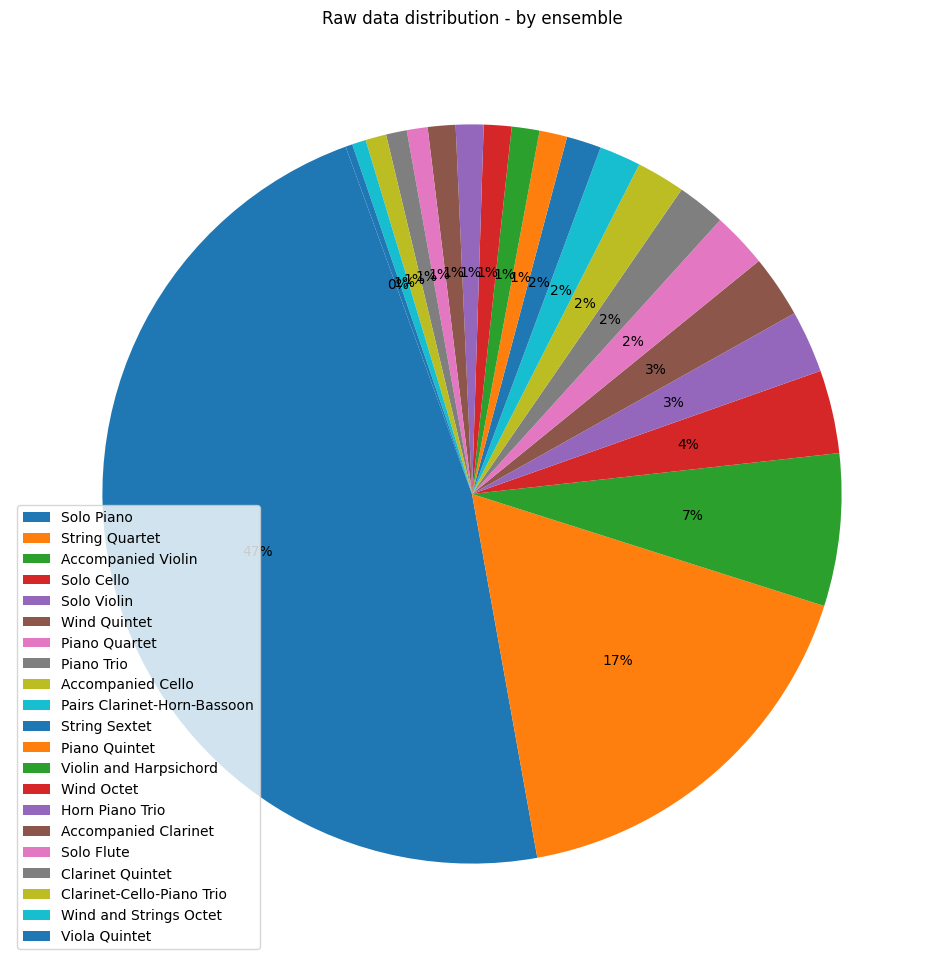

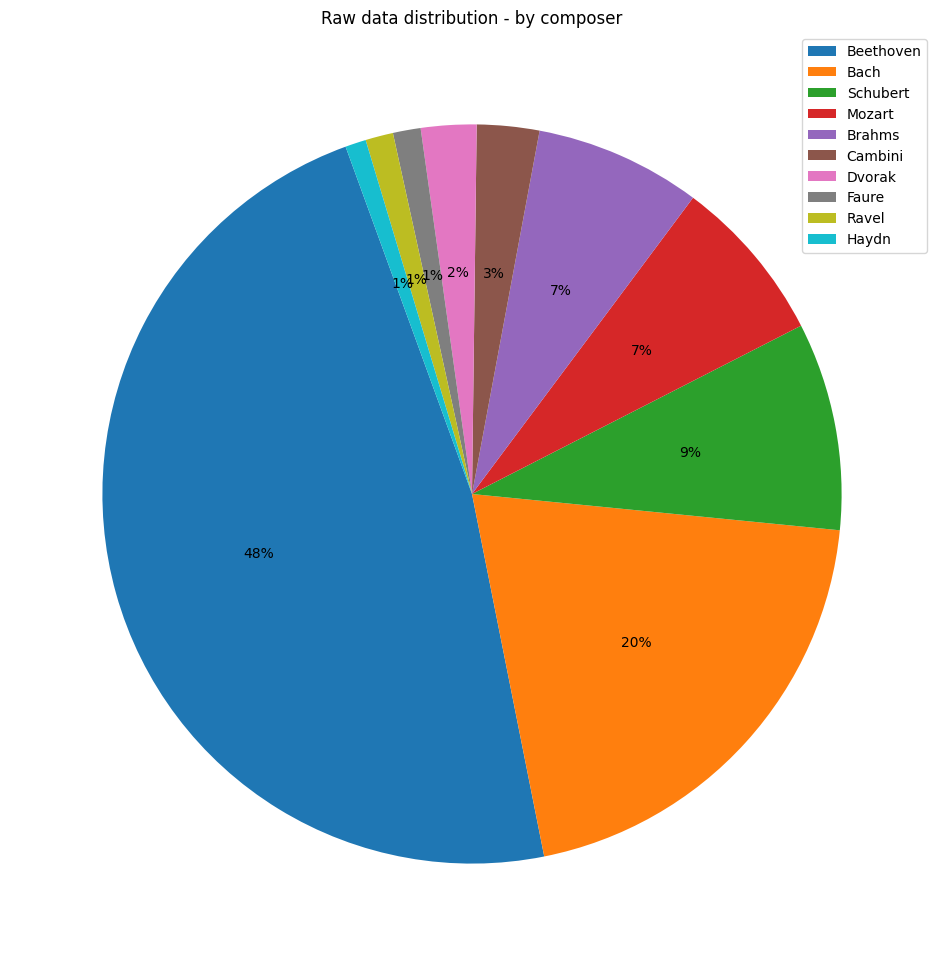

In [ ]:
metadata = pd.read_csv(proj_path + "/musicnet_metadata.csv")

ensemble = metadata['ensemble'].value_counts()

label= [ensemble.index.tolist()]
plt.pie(ensemble, autopct='%1.0f%%', startangle=110)
plt.gcf().set_size_inches(12,12)
plt.legend(labels=label[0], loc="best")
# plt.style.use('seaborn')
plt.title("Raw data distribution - by ensemble")
plt.show()

composer = metadata['composer'].value_counts()
plt.pie(composer, autopct='%1.0f%%', startangle=110)
plt.gcf().set_size_inches(12,12)
plt.legend(labels=composer.index.tolist(), loc="best")
# plt.style.use('seaborn')
plt.title("Raw data distribution - by composer")
plt.show()

In order to balance the data, we had to build a function that extacts the list of balanced files.

Let us examine the results of the function:

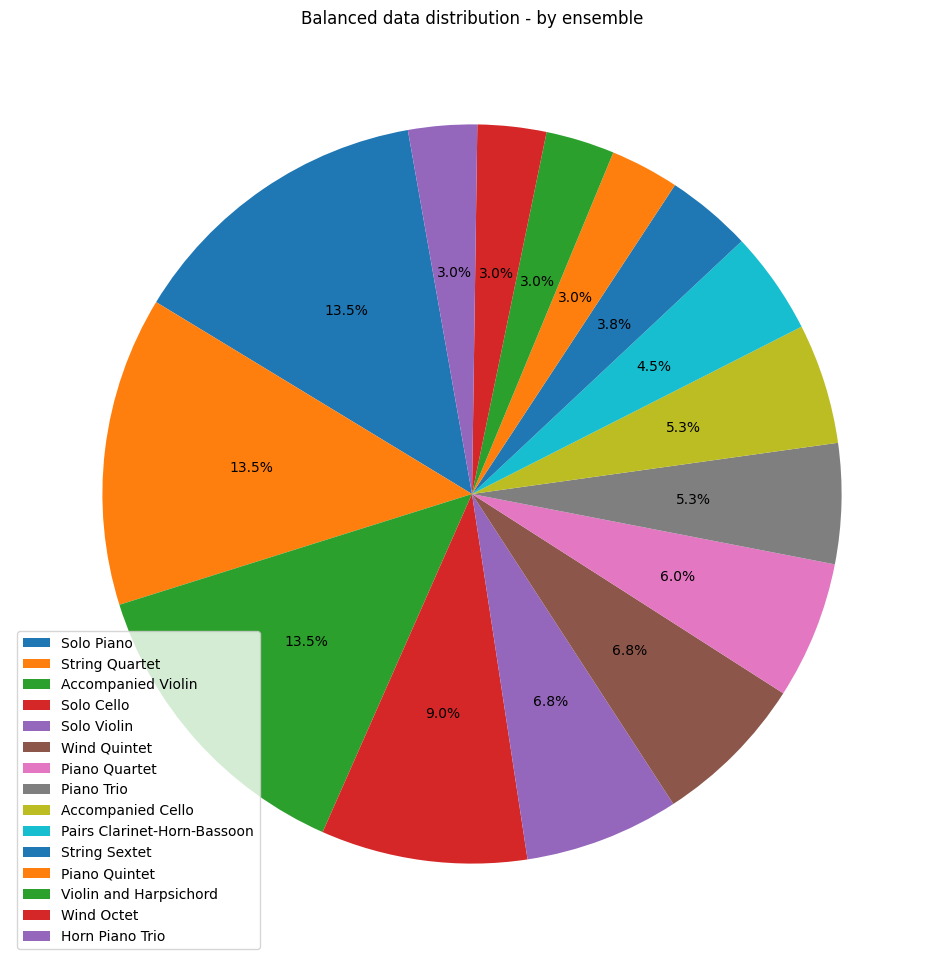

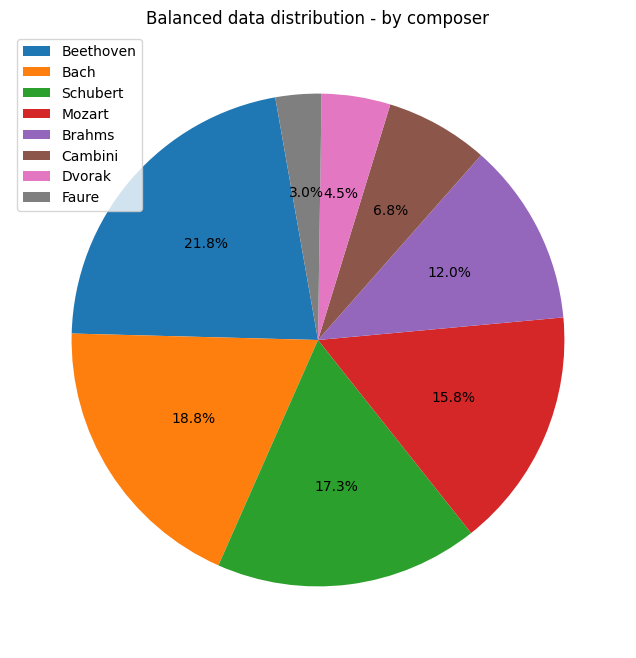

In [ ]:
def balance_ensemble(metadata, max_repetitions=10, number_of_instruments=13):
    # Get the number of rows for each ensemble
    ensemble_counts = metadata['ensemble'].value_counts()

    # Get the top 10 most frequent ensembles
    top_ensembles = ensemble_counts.index[:number_of_instruments]

    # Create a new DataFrame with a maximum of 10 repetitions of each ensemble
    balanced_metadata = pd.DataFrame(columns=metadata.columns)
    deleted_files = []
    for ensemble in top_ensembles:
        ensemble_rows = metadata[metadata['ensemble'] == ensemble].head(max_repetitions)
        deleted_files += list(metadata[metadata['ensemble'] == ensemble][max_repetitions:]['id'])
        balanced_metadata = pd.concat([balanced_metadata, ensemble_rows])

    return balanced_metadata, deleted_files



metadata = pd.read_csv(proj_path + "/musicnet_metadata.csv")
balanced_metadata, deleted_files = balance_ensemble(metadata,18,15)

# Plot the pie charts for the balanced data
ensemble = balanced_metadata['ensemble'].value_counts()
label = [ensemble.index.tolist()]
plt.pie(ensemble, autopct='%1.1f%%', startangle=100)
plt.gcf().set_size_inches(12, 12)
plt.legend(labels=label[0], loc="best")
# plt.style.use('seaborn')
plt.title("Balanced data distribution - by ensemble")
plt.show()

composer = balanced_metadata['composer'].value_counts()
label = [composer.index.tolist()]
plt.pie(composer, autopct='%1.1f%%', startangle=100)
plt.gcf().set_size_inches(8, 8)
plt.legend(labels=label[0], loc="best")
# plt.style.use('seaborn')
plt.title("Balanced data distribution - by composer")
plt.show()


In [ ]:
print("Balanced data length: ",len(balanced_metadata))
print("Deleted files length: ", len(deleted_files))


Balanced data length:  133
Deleted files length:  181


So we deleted 181 files, but now our data is balanced.

Looks good. We managed to balance our data ensemble-wise and composer-wise.

**Note:** the fact that we balanced our ensembles in the training data doesnt necessarilly mean that we balanced the labels of all the *shorts*.

Lets examine the labels of the songs that remained in the balanced data:

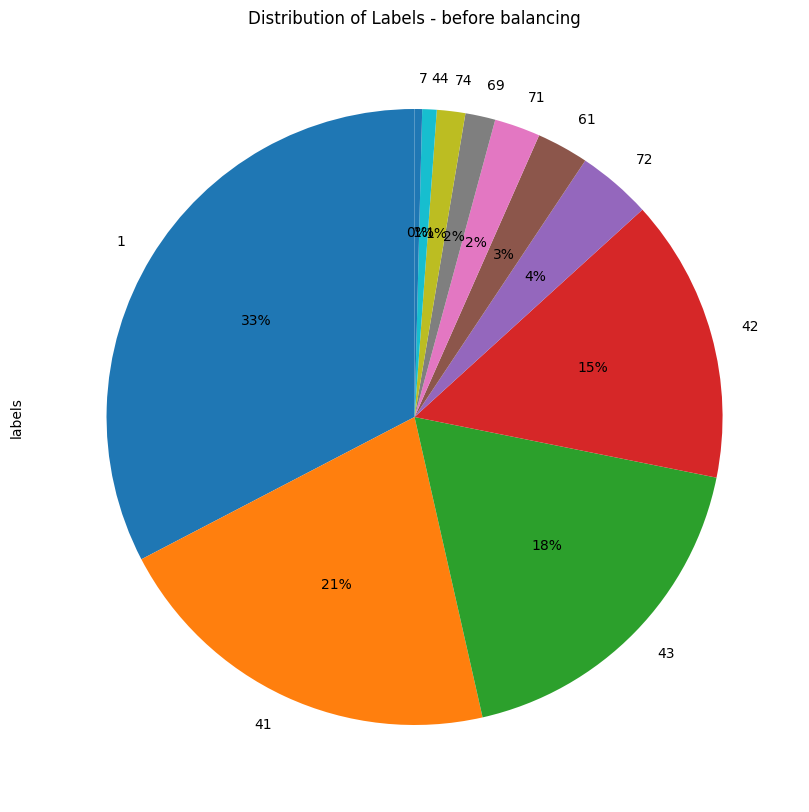

In [ ]:
train_labels_balan = extract_labels(train_labels_path, train_files)
train_labels_balan.sort()
list_of_dicts_train_balan = create_dict(train_labels_path, train_labels_balan)
list_one_hot_vecs_train_balan = create_one_hot(list_of_dicts_train_balan)

total_labels = []

# Loop over the list of dictionaries
for d in list_of_dicts_train_balan:
    # Add the keys from each dictionary to the keys list
    total_labels += d.values()

total_flattened_labels = [item for sublist in total_labels for item in sublist]
flattened_labels_df = pd.DataFrame(total_flattened_labels, columns=['labels'])
label_counts = flattened_labels_df['labels'].value_counts()

plt.figure(figsize=(10,10))

# Plot the distribution of the labels as a pie chart
label_counts.plot.pie(autopct='%1.0f%%', startangle=90)

# Add a title to the chart
plt.title("Distribution of Labels - before balancing")

# Show the chart
plt.show()



Most common label: 1


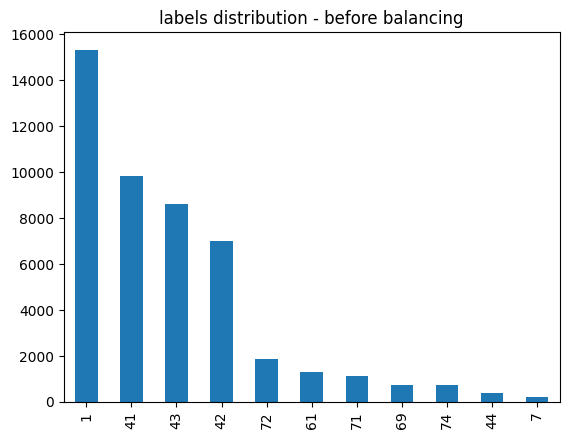

In [ ]:
print(f'Most common label: {label_counts.index[0]}')

label_counts.plot(kind='bar')
plt.title('labels distribution - before balancing')
pass


### **Creating the balanced data tuples:**


during the work on the project, we realized that loading the data takes much more time then expected. so, in the following part we load the songs, divide them to shorts, labels them, and save the processed data to the drive.

**Note:** this part is to be executed only once, since it takes a long time and saves the data compressed data to the drive.



In [ ]:
train_data_balan, trainfiles5_balan = loadTrainData(0,315,train_files,train_path,deleted_files=deleted_files)
train_data_5sec_balan = divideToShorts(train_data_balan)
train_labels_balan = extract_labels(train_labels_path, trainfiles5_balan)
train_labels_balan.sort()
list_of_dicts_train_balan = create_dict(train_labels_path, train_labels_balan)
list_one_hot_vecs_train_balan = create_one_hot(list_of_dicts_train_balan)
train_data_tuples_balan = create_tuples(train_data_5sec_balan,list_one_hot_vecs_train_balan)
train_batches_balan, val_batch = divide_and_batch_tensor(train_data_tuples_balan,batch_size = 80,validation_percentage=0.1)
with open(models_path + 'train_batches_balan.pkl', 'wb') as file:
        pickle.dump(train_batches_balan, file)

with open(models_path + 'val_batch.pkl', 'wb') as file:
        pickle.dump(val_batch, file)



analyzing the balanced data:

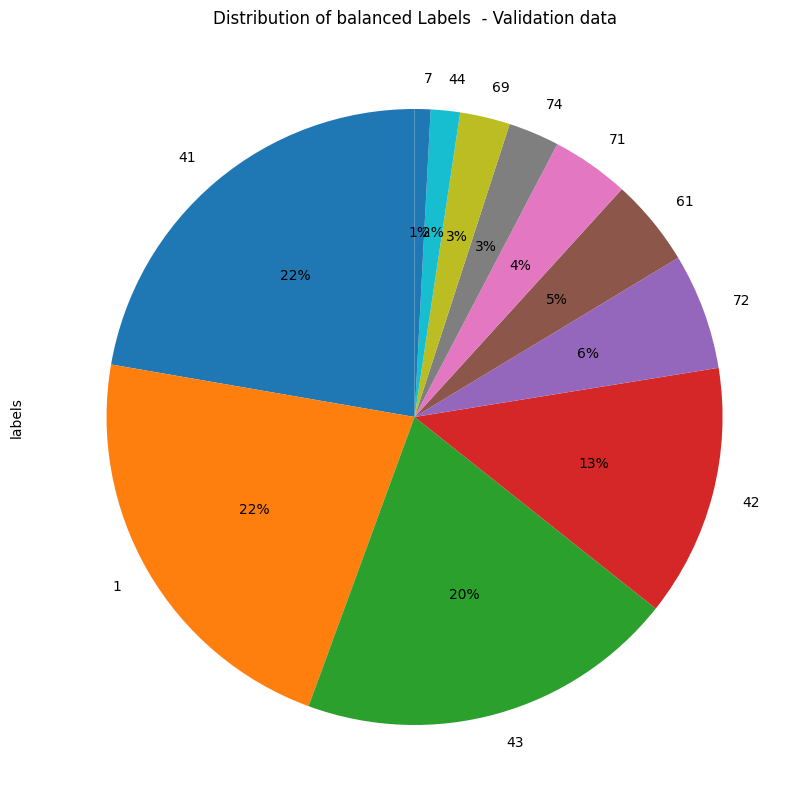

Most common label: 41


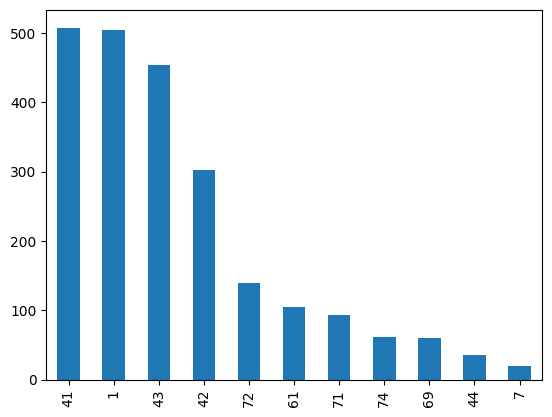

In [ ]:
labels_list = [np.argwhere(val_batch[0][1][j] > 0.5).flatten().cpu().detach().numpy() for j in range(912)]
flattened_labels = [item for sublist in labels_list for item in sublist]
flattened_labels_df = pd.DataFrame(flattened_labels, columns=['labels'])
label_counts = flattened_labels_df['labels'].value_counts()

plt.figure(figsize=(10,10))
label_counts.plot.pie(autopct='%1.0f%%', startangle=90)

# Add a title to the chart
plt.title("Distribution of balanced Labels  - Validation data")

# Show the chart
plt.show()

print(f'Most common label: {label_counts.index[0]}')
label_counts.plot(kind='bar')
pass

In [ ]:
with open(models_path + 'train_batches_balan.pkl', 'rb') as file:
    train_batches_balan = pickle.load(file)
with open(models_path + 'val_batch.pkl', 'rb') as file:
    val_batch = pickle.load(file)

labels_list = [np.argwhere(train_batches_balan[i][1][j] > 0.5).flatten().cpu().detach().numpy() for i in range(759) for j in range(15)]

flattened_labels = [item for sublist in labels_list for item in sublist]
flattened_labels_df = pd.DataFrame(flattened_labels, columns=['labels'])
label_counts = flattened_labels_df['labels'].value_counts()

plt.figure(figsize=(10,10))
label_counts.plot.pie(autopct='%1.0f%%', startangle=90)

# Add a title to the chart
plt.title("Distribution of balanced Labels ")

# Show the chart
plt.show()


In [ ]:
print(f'Most common label: {label_counts.index[0]}')
label_counts.plot(kind='bar')
pass

Good, we kept the same distribution.

One might notice an interesting fact: out of a labels-space of 128 possibilities, we see that in the raw and in the balanced data we got only 11 intruments taking part!

This fact will serve us when building the NN's, so we can reduce the outputs from 128 to 11.

## **Data compression**

So now we can compress our batches, from output of 128, to output of 11 only!

Let's make sure our function worked properly:

In [ ]:
labels_list = [np.argwhere(reduce_to_11(train_batches_balan[i])[1][j] > 0.5).flatten().cpu().detach().numpy() for i in range(142) for j in range(80)]

flattened_labels = [item for sublist in labels_list for item in sublist]
flattened_labels_df = pd.DataFrame(flattened_labels, columns=['labels'])
label_counts = flattened_labels_df['labels'].value_counts()

plt.figure(figsize=(10,10))
label_counts.plot.pie(autopct='%1.0f%%', startangle=90)

# Add a title to the chart
plt.title("Distribution of reduced Labels ")

# Show the chart
plt.show()

print(f'Most common label: {label_counts.index[0]}')
label_counts.plot(kind='bar')
pass


# 1.4. Presenting the data

### First, we will have to load the **files**:

In [ ]:
with open(models_path + 'train_batches_balan.pkl', 'rb') as file:
    train_batches_balan = pickle.load(file)
with open(models_path + 'val_batch.pkl', 'rb') as file:
    val_batch = pickle.load(file)


each piece of music is labeled with a csv file, indicating what instrument is playin in each exact part of the song.

In [ ]:
train_files.sort()
train_labels = extract_labels(train_labels_path,train_files)
train_labels.sort()
first_file =train_labels[0]
print(f"The first file is: {first_file}")
first_df = pd.read_csv(os.path.join(train_labels_path, first_file))
print(first_df.head())

### **Let's listen to an audio:**

**Note:** train_batches_balan is our training data.

each element in it is a batch, contaning 80 pieces of music (5 seconds each), and its labels.

for example, in this piece of music:

In [ ]:
Audio(data=train_batches_balan[0][0][0], rate=22050)

**The label is:**

In [ ]:
reduce_to_11(train_batches_balan[0])[1][0]

**meaning the instruments taking part are:**

1. Acustic Grand Piano

2. Violin

3. Viola

4. Cello

# **1.5. Train part - time domain**

In this part we started analyzing every *short* using a CNN architecture.

Every song is sampled with a sample rate of 22050 samples per second.

Like we saw in class, when interprating sound samples, we are looking for staionarity and locality attributes. Thus, every network should consist of some convlutional layers to begin with, and then some fully conected layers.



First, we defined some auxillary functions, and then train function.
when building the train function we struggled choosing the right loss funcion: since our task is a multilabeling task, we needed to adjust our loss function and accuracy funcion to be suitable.


At the beggining we tried the nn.BCEwithlogits function, and later tried also the nn.MultiLabelMarginLoss. But, since most of our shorts are labeled with a singlr instrument, we realized that this loss function causes the modeles output to vanish to 0, and indirectly increased the accuracy, but didn't make any process of learning.

Thus, we changed the loss function back to bt the cross entropy loss function, which is the most common lost function for these kind of tasks.

The accuracy function usually used in multilabelig tasks is the F1 score, implemented in the next cell.

The optmizer we used was the ADAM optimizer, which was the optimzer we used along the semester. In the task, we didnt have any problem of convergence, thus we didnt see any superiority in changing it.



In [ ]:
def f1_score(real_indices, predicted_indices):
    true_positives = len(set(real_indices) & set(predicted_indices))
    false_positives = len(set(predicted_indices) - set(real_indices))
    false_negatives = len(set(real_indices) - set(predicted_indices))
    precision = true_positives / (true_positives + false_positives + 1e-9)
    recall = true_positives / (true_positives + false_negatives + 1e-9)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
    return round(f1,6)


def get_accuracy(output,target):
    score = 0
    length = 0
    for prediction,label in zip(output,target):
      predicted_indices = np.argwhere(prediction.cpu() > 0.5).flatten()
      real_indices = np.argwhere(label.cpu() > 0.5).flatten()
      score += f1_score(real_indices.cpu().detach().numpy(), predicted_indices.cpu().detach().numpy())
      length += 1
    return round(score/length,6)


def plot_learning_curve(train_losses,train_accs,iters,val_losses,val_accs,val_iters,iter):
    """
    Plot the learning curve.
    """
    train_losses,train_accs = [t.cpu().detach().numpy() for t in train_losses], [t for t in train_accs]
    val_losses,val_accs = [t.cpu().detach().numpy() for t in val_losses], [t for t in val_accs]
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, train_losses, label="Train")
    plt.plot(val_iters, val_losses, label="Validation")
    plt.legend(loc='best')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")

    plt.plot(iters, train_accs, label="Train")
    plt.plot(val_iters, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    return


def train(model,train_batches,validation_tups,num_epochs,max_iters,lr,chckpt,prev_res):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_losses,train_accs,iters,val_losses,val_accs,val_iters,iter = prev_res
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    validation_tups = reduce_to_11(validation_tups)
    print(str(model)[:10])
    for epoch in range(num_epochs):
        print("epoch =", epoch)
        for batch in train_batches:
            model.train()
            batch = reduce_to_11(batch)
            input = batch[0].unsqueeze(1).to(device) # Add channel dimension
            output = model(input)
            target = batch[1].to(device)
            loss = criterion(output,target)
            acc = get_accuracy(output,target)
            print("iteration no.: ",iter, "train accuracy is: ", 100*acc , "% ","loss: ",loss.cpu().detach().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_accs.append(acc)
            train_losses.append(loss)
            iters.append(iter)
            iter +=1
            if iter > max_iters:
                return train_losses,train_accs,iters,val_losses,val_accs,val_iters,iter

            if iter % 23 == 0:
                model.eval()
                val_input =validation_tups[0].unsqueeze(1).to(device) # Add channel dimension
                val_target = validation_tups[1].to(device)
                val_output = model(val_input)
                val_loss = criterion(val_output,val_target)
                val_losses.append(val_loss)
                val_acc = get_accuracy(output,val_target)
                val_accs.append(val_acc)
                val_iters.append(iter)
                # print("iteration no.: ",iter, "train accuracy is: ", 100*acc , "% ","loss: ",loss.cpu().detach().numpy())
                print("iteration no.: ",iter, "val accuracy is: ", 100*val_acc , "% ","val loss: ",val_loss.cpu().detach().numpy())
                if chckpt:
                  torch.save(model.state_dict(), chckpt +str(model)[:10] + "checkpt_noon_Feb_4 {}".format(iter))

    return train_losses,train_accs,iters,val_losses,val_accs,val_iters,iter

## **CNN-time-7**

Now, we started with a heavy network, consinste of 5 convolutional layers, and 2 fully-connected.
the kernel size of each layer is 1250, which is about 0.06 seconds when the sample rate is 22050.

In [ ]:
class CNN_time_7(nn.Module):
    def __init__(self, n=1, kernel_size=1250):
        super(CNN_time_7, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=n, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(in_channels=n, out_channels=n*2, kernel_size=kernel_size, padding=1)
        self.conv3 = nn.Conv1d(in_channels=n*2, out_channels=n*4, kernel_size=kernel_size, padding=1)
        self.conv4 = nn.Conv1d(in_channels=n*4, out_channels=n*8, kernel_size=kernel_size, padding=1)
        self.conv5 = nn.Conv1d(in_channels=n*8, out_channels=n*16, kernel_size=kernel_size, padding=1)


        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool1d(kernel_size=8, stride=8)
        self.pool3 = nn.MaxPool1d(kernel_size=12, stride=12)
        self.fc1 = nn.Linear(in_features=240, out_features=80)
        self.fc2 = nn.Linear(in_features=80, out_features=11)

        self.dropout = nn.Dropout(p=0.15)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool1(F.relu(self.conv2(x)))
        x = self.pool1(F.relu(self.conv3(x)))
        x = self.pool2(F.relu(self.conv4(x)))
        x = self.pool3(F.relu(self.conv5(x)))
        x = x.flatten(start_dim=1)
        x = self.dropout(F.leaky_relu(self.fc1(x),negative_slope=0.1))
        # x = self.sigmoid(x)
        x = self.sigmoid(F.leaky_relu(self.fc2(x),negative_slope=0.1))
        return x



We tried this network for one epoch and examined the results:



In [ ]:
CNN7 = CNN_time_7()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN7.to(device)
iter = 0
iters = []
val_iters = []
epochs = []
train_losses = []
val_losses = []
train_accs = []
val_accs = []
res_2007 = train_losses,train_accs,iters,val_losses,val_accs,val_iters,iter
res_2007 = train(CNN7,train_batches_balan,val_batch[0],num_epochs=5,max_iters=750,lr=0.0003,chckpt= models_path,prev_res = res_2007)
plot_learning_curve(*res_2007)



with open(models_path + 'res_2007.pkl', 'wb') as file:
            pickle.dump(res_2007, file)


The accuracy seems to be more or less flat at the end of the epoch, and around 60%.

lets try some lighter network:

## **CNN-time-6**

In this architecture, we tried to reduce the number of variables, making it easier to run an epoch.

In order to do it, we reduced the kernel size of each layer to 750, and eliminated 1 convolutional layer.

Let us examine the results of this network:

In [ ]:
class CNN_time_6(nn.Module):
    def __init__(self, n=1, kernel_size=750):
        super(CNN_time_6, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=n, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(in_channels=n, out_channels=n*2, kernel_size=kernel_size, padding=1)
        self.conv3 = nn.Conv1d(in_channels=n*2, out_channels=n*4, kernel_size=kernel_size, padding=1)
        self.conv4 = nn.Conv1d(in_channels=n*4, out_channels=n*8, kernel_size=kernel_size, padding=1)
        self.conv5 = nn.Conv1d(in_channels=n*8, out_channels=n*16, kernel_size=kernel_size, padding=1)


        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=10)
        self.pool2 = nn.MaxPool1d(kernel_size=3, stride=4)
        self.fc1 = nn.Linear(in_features=584, out_features=11)
        self.fc2 = nn.Linear(in_features=11, out_features=11)

        self.dropout = nn.Dropout(p=0.15)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool2(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))
        x = self.pool1(F.relu(self.conv4(x)))
        # x = self.pool1(F.relu(self.conv5(x)))
        x = x.flatten(start_dim=1)
        x = self.dropout(F.leaky_relu(self.fc1(x),negative_slope=0.1))
        # x = self.sigmoid(x)
        x = self.sigmoid(F.leaky_relu(self.fc2(x),negative_slope=0.1))
        return x


In [ ]:
CNN6 = CNN_time_6()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN6.to(device)
iter = 0
iters = []
val_iters = []
epochs = []
train_losses = []
val_losses = []
train_accs = []
val_accs = []
res_2006 = train_losses,train_accs,iters,val_losses,val_accs,val_iters,iter
res_2006 = train(CNN6,train_batches_balan,val_batch[0],num_epochs=1,max_iters=750,lr=0.0003,chckpt= models_path,prev_res = res_2006)
plot_learning_curve(*res_2006)



with open(models_path + 'res_2006.pkl', 'wb') as file:
            pickle.dump(res_2006, file)


One might see that the accuracy kept increasing even in the end of the epoch, while the loss kept decreasing. Therefore, we decided to keep trying to improve this network for some more epochs.

In [ ]:

CNN6 = CNN_time_6()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN6.to(device)
iter = 0
iters = []
val_iters = []
epochs = []
train_losses = []
val_losses = []
train_accs = []
val_accs = []
res_2006 = train_losses,train_accs,iters,val_losses,val_accs,val_iters,iter
res_2006 = train(CNN6,train_batches_balan,val_batch[0],num_epochs=6,max_iters=1000,lr=0.0003,chckpt= models_path,prev_res = res_2006)
plot_learning_curve(*res_2006)



with open(models_path + 'res_2006.pkl', 'wb') as file:
            pickle.dump(res_2006, file)


### **Overfitting**

One might see the pattern of overfitting starting to occur after around 600-650 iteration. In order to clarify our suspect, we ran the model for one more epoch, and we clearly saw the gap created between the *validation accuracy* and the *training accuracy*.

Thus, the model that has the best detection accuracy is expected to bo be the model from checkpoint ~600.

## **CNN-time-5**

We decided to try one more archtecture.

This time, the architecture consists of 5 convolutional layers, and 1 fully-connected.

we ran this network for 1 epoch to see if it outperforms significantilly the previuos one, or not:

In [ ]:
class CNN_time_5(nn.Module):
    def __init__(self, n=1, kernel_size=750):
        super(CNN_time_5, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=n, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(in_channels=n, out_channels=n*2, kernel_size=kernel_size, padding=1)
        self.conv3 = nn.Conv1d(in_channels=n*2, out_channels=n*4, kernel_size=kernel_size, padding=1)
        self.conv4 = nn.Conv1d(in_channels=n*4, out_channels=n*8, kernel_size=kernel_size, padding=1)
        self.conv5 = nn.Conv1d(in_channels=n*8, out_channels=n*16, kernel_size=kernel_size, padding=1)


        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=10)
        self.pool2 = nn.MaxPool1d(kernel_size=3, stride=4)
        self.fc1 = nn.Linear(in_features=584, out_features=11)
        # self.fc2 = nn.Linear(in_features=128, out_features=128)

        self.dropout = nn.Dropout(p=0.15)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool2(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))
        x = self.pool1(F.relu(self.conv4(x)))
        # x = self.pool1(F.relu(self.conv5(x)))
        x = x.flatten(start_dim=1)
        x = self.dropout(F.leaky_relu(self.fc1(x),negative_slope=0.1))
        x = self.sigmoid(x)
        # x = self.sigmoid(F.leaky_relu(self.fc2(x),negative_slope=0.1))
        return x



In [ ]:
CNN5 = CNN_time_5()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN5.to(device)
iter = 0
iters = []
val_iters = []
epochs = []
train_losses = []
val_losses = []
train_accs = []
val_accs = []
res_2000 = train_losses,train_accs,iters,val_losses,val_accs,val_iters,iter
res_2000 = train(CNN5,train_batches_balan,val_batch[0],num_epochs=1,max_iters=750,lr=0.0001,chckpt= models_path,prev_res = res_2000)
plot_learning_curve(*res_2000)



with open(models_path + 'res_2000.pkl', 'wb') as file:
            pickle.dump(res_2000, file)


One might see the this network is expected to be worse than CNN_time_6, thus we stopped training it after 1 epoch.

# **1.6. Test - time domain:**

Now, its time to test the model that recieved the highest accuracy on the validation data:

In [ ]:
def test_acc(model,test_tups):
    test_tups = reduce_to_11(test_tups)
    criterion = nn.BCEWithLogitsLoss()
    model.eval()
    test_input =test_tups[0].unsqueeze(1).to(device) # Add channel dimension
    test_target = test_tups[1].to(device)
    test_output = model(test_input).to(device)
    print("labels of sample:")
    print(test_target[1])
    print("the models prediction for the sample:")
    print(test_output[1])
    test_loss = criterion(test_output,test_target)
    test_acc = get_accuracy(test_output,test_target)
    print("In conclusion:")
    print("test accuracy is: ", 100*test_acc , "% ","test loss: ",test_loss.item())

    return


In [ ]:
with open(models_path + 'test_batch.pkl', 'rb') as file:
    test_batches = pickle.load(file)


In [ ]:
#gettting test accuracy:

test_model = CNN_time_6
test_model.load_state_dict(torch.load("/content/gdrive/My Drive/Intro_to_Deep_Learning/project/models/CNN_time_6checkpt_noon_Feb_4 598"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model.to(device)



test = test_acc(test_model,test_batches[0])

# **2. Frequency domain**

One can see that the in the time domain, after a few epochs the accuracy convereged at around 60 precent. According to several references we found out that our model may get better results by working in the frequency domain. Working with audio signals in the frequency domain, as opposed to the time domain, has several advantages in the context of audio recognition models such as more emphasize on frequency information, reduction of temporal variability,enhanced feature extraction. Usually the frequency-domain representation of audio signals can provide valuable information for audio recognition models and make it easier to perform accurate and robust recognition tasks.

# 2.1. Spectogram for a specific short

One can see that by presenting a short by a spectogram, it turns out be a plot that can be referred to as an image. The goal in the frequency domain is to extract features which look like images and shape them in a way in order to feed them into a CNN.

Why CNNS?

CNNs are a popular deep learning architecture that are often used for image classification tasks. They are well suited for processing 2D images and are effective at capturing the spatial structure of the input data. By treating the Mel spectrogram as an image, it is possible to leverage the strengths of CNNs for audio processing tasks.

In [ ]:
# Compute STFT using librosa.stft
song = train_batches_balan[0][0][0] #specific short
song = song.detach().numpy()
stft = librosa.stft(song, n_fft=100, hop_length=1000)

# Plot spectrogram
plt.figure(figsize=(10, 5))
librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max), sr=22050, y_axis='linear', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT Magnitude SHORT')
plt.tight_layout()
plt.show()

In [ ]:
mfccs = librosa.feature.mfcc(song, sr=22050, n_mfcc=13) # compute MFCCs using 13 channels

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=22050, x_axis='time')
plt.colorbar()
plt.title('MFCC SHORT')
plt.tight_layout()
plt.show()

## 2.2. Functions working with shorts in frequency domain

While working in the frequency domain, most of the functions that were build to train the models in the time domain could be reused, though while transforming the data another dimenstion was added. Therefore, some adjustments were made to some of the functions.

For a part of the time the notebook was run on the CPU and sometime on the GPU which results in different types of saving the pickle files. In order to load those files the function CPU_unpickler was added.

In [ ]:
def reduce_to_11_freq(labels, indices = [1,7,41,42,43,44,61,69,71,72,74]):
    targets = labels
    reduced_targets = torch.zeros((targets.shape[0],len(indices)))

    for j,target in enumerate(targets):
        reduced_target = torch.zeros(len(indices))
        reduced_target = target[indices]
        reduced_targets[j] = reduced_target

    return reduced_targets


def create_tuples_freq(batch_m ,labels ):
    train_data_tuples = []
    for short, one_hot in zip(batch_m, labels):
        train_data_tuples.append((torch.tensor(short), torch.tensor(one_hot)))
    return train_data_tuples


def divide_and_batch_tensor_freq(train_data_tuples, batch_size,seed):
    random.seed(seed)
    random.shuffle(train_data_tuples)
    def get_batch(batch_data):
        inputs = [x[0] for x in batch_data]
        labels = [x[1] for x in batch_data]
        return torch.stack(inputs), torch.stack(labels)

    batches = [get_batch(train_data_tuples[i:i + batch_size]) for i in range(0, len(train_data_tuples), batch_size)]

    return batches


import io
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

# 2.3. MFCC Models


In total we made 4 tries for different architectures to train mfccs which are given by 13 channels and 216 frames each. Preparing to train the model, first the validation data is transformed and its labels are reduced to 11 labels as explained in the data analysing.
The train function defined here was used for all the models that worked with mfcc. Since a lack of RAM sources, the training process was stopped often. The flag prev_res helped to handlel this problem, which indicates if the current training is a continue of the last state of traineng or not. Moreover the training was always done on one epoch, saved and continued training. While training the leaning rate was adjusted as getting the current results.

The Mel-frequency cepstral coefficients (MFCCs) are a widely used representation of audio signals in speech and music recognition tasks. The main advanteges of this transform are; Efficient computation, dimensionality reduction and perceptually motivated.
MFCCs are a well-established and widely used representation of audio signals that offer a good trade-off between robustness, computational efficiency, and information content. They are particularly well suited for speech and music recognition tasks, where human perception is an important consideration.
One of the limitations in recognizing instruments are the RAM memory resources and therefore a compressed transform like mfccs could overcome this problem.

In [ ]:
from scipy.fftpack import dct

def batch_shorts_to_mfcc(batch,in_train = False):
  if (in_train == True):
    tensor = torch.zeros(80,13,216)
  else:
    mfccs_freqs = []
  for i in range(batch.shape[0]):
      song = batch[i,:].detach().numpy()
      # Compute MFCCs
      mfccs = librosa.feature.mfcc(song, sr=22050, n_mfcc=13) #says how many channels are used
      # Convert to frequency domain
      mfccs_freq = dct(mfccs, type=2, axis=0, norm='ortho')
      if (in_train == True):
        tensor[i] = torch.tensor(mfccs_freq)
      else:
        mfccs_freqs.append(torch.tensor(mfccs_freq))
  if (in_train):
    return tensor
  return mfccs_freqs


### CNN-freq-5 & CNN-freq-6
Model CNN_freq_6 and Model CNN_freq_5 are quit similar models while the main difference between the models is the kernel size. As getting an input of 13 channel with 216 frames each, the kernel size used effects strongly the computation efficiency. Meaning, that using the greater kernel size even if computing always each epoch seperately the computation time is very long compared to the smaller one. As trying to find the best solution, taking the accuracy and the computation time in account, we found out that both the models are about the same accuracy, just one takes much longer. The Accuracy reached by these model is around 52%.

In [ ]:
class CNN_freq_5(nn.Module):
    def __init__(self):
        super(CNN_freq_5, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=13, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1)

        self.pool = nn.MaxPool1d(kernel_size=10, stride=2,padding = 5)
        self.fc1 = nn.Linear(in_features=4096, out_features=300)
        self.fc2 = nn.Linear(in_features=300, out_features=11)
        self.dropout = nn.Dropout(p=0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.flatten(start_dim=1)
        x = self.dropout(F.leaky_relu(self.fc1(x),negative_slope=0.1))
        x = self.sigmoid(F.leaky_relu(self.fc2(x),negative_slope=0.1))
        x = self.sigmoid(x)
        return x

In [ ]:
class CNN_freq_6(nn.Module):
    def __init__(self):
        super(CNN_freq_6, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=13, out_channels=50, kernel_size=20, padding=10)
        self.conv2 = nn.Conv1d(in_channels=50 , out_channels=100, kernel_size=20, padding=10)
        self.conv3 = nn.Conv1d(in_channels=100, out_channels=200,  kernel_size=20, padding=10)
        self.conv4 = nn.Conv1d(in_channels=200, out_channels=400, kernel_size=20, padding=10)

        self.pool = nn.MaxPool1d(kernel_size=10, stride=2 ,padding = 5)
        self.fc1 = nn.Linear(in_features=6400, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=11)
        self.dropout = nn.Dropout(p=0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.flatten(start_dim=1)
        x = self.dropout(F.leaky_relu(self.fc1(x),negative_slope=0.1))
        x = self.sigmoid(F.leaky_relu(self.fc2(x),negative_slope=0.1))
        return x

## CNN-freq-7 & CNN-freq-8

As we read in the references added later to the report, for 2D input (similar to image processing) it is recommended to use 2D  convolutional layers instead of 1D convolutional layers.

Both models CNN_freq_7 and CNN_freq_8 are build by 4 2D convolutional layers nn.Conv2d (different than nn.Conv1d) and 2 fully connected linear layers are added.
Using the model CNN_freq_7 we found out the the computation time higly improved, but the accuracy converged quickly to around 55%.

The second model CNN_freq_8  has a 2D convolutional layer including a 2D kernel with more dropout layer. Since the model converged quikly for CNN_freq_7, we assumed that more dropout could help to train the model better while also raising the computation requirments of the model. Though it turned out to be to hard to compute with similar results and therefore the model CNN_freq_7 was chosen to be the best option of the MFCC transformed shorts.

In [ ]:
#2D Convolutional layers

class CNN_freq_7(nn.Module):
    def __init__(self):
        super(CNN_freq_7, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=13, out_channels=50, kernel_size=(20,1), padding=(10,0))
        self.conv2 = nn.Conv2d(in_channels=50 , out_channels=100, kernel_size=(20,1), padding=(10,0))
        self.conv3 = nn.Conv2d(in_channels=100, out_channels=200, kernel_size=(20,1), padding=(10,0))
        self.conv4 = nn.Conv2d(in_channels=200, out_channels=400, kernel_size=(20,1), padding=(10,0))

        self.pool = nn.MaxPool2d(kernel_size=(10,1), stride=(2,1), padding=(5,0))
        self.fc1 = nn.Linear(in_features=6400, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=11)
        self.dropout = nn.Dropout(p=0.2)
        self.dropout1 = nn.Dropout(p=0.05)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(3)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = x.flatten(start_dim=1)
        x = self.dropout(F.leaky_relu(self.fc1(x),negative_slope=0.1))
        x = self.sigmoid(F.leaky_relu(self.fc2(x),negative_slope=0.1))

        return x


In [ ]:
class CNN_freq_8(nn.Module):
    def __init__(self):
        super(CNN_freq_8, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=13, out_channels=50, kernel_size=(10, 10), padding=(5, 5))
        self.dropout1 = nn.Dropout(p=0.05)
        self.conv2 = nn.Conv2d(in_channels=50 , out_channels=100, kernel_size=(10, 10), padding=(5, 5))
        self.dropout2 = nn.Dropout(p=0.05)
        self.conv3 = nn.Conv2d(in_channels=100, out_channels=200,  kernel_size=(10, 10), padding=(5, 5))
        self.dropout3 = nn.Dropout(p=0)
        self.conv4 = nn.Conv2d(in_channels=200, out_channels=400, kernel_size=(10, 10), padding=(5, 5))
        self.dropout4 = nn.Dropout(p=0.1)
        self.pool = nn.MaxPool2d(kernel_size=(5, 5), stride=2, padding = (2, 2))
        self.fc1 = nn.Linear(in_features=6000, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=11)
        self.dropout5 = nn.Dropout(p=0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(3)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout4(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.dropout5(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


In [ ]:

def trainFNN(model, num_epochs, batch_size, lr, chckpt, validation_tups, train_data,res_fnn_prev, seed = 0,prev_res=False):

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        if (prev_res == False):
            iter = 0
            iters = []
            val_iters = []
            epochs = []
            train_losses = []
            val_losses = []
            train_accs = []
            val_accs = []
        else:
            train_losses,train_accs,iters,val_losses,val_accs,val_iters,iter =  res_fnn_prev

        for epoch in range(num_epochs):
              if(len(train_data[0])< batch_size):
                break
              model.train()
              target =reduce_to_11_freq(train_data[1])
              input = batch_shorts_to_mfcc(train_data[0],True)
              output = model(input)
              loss = criterion(output, target)
              acc = get_accuracy(output, target)
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              train_accs.append(acc)
              train_losses.append(loss)
              iters.append(iter)
              iter +=1
              if iter%23 ==0 :
                if chckpt:
                    torch.save(model.state_dict(), chckpt + "freq7_BCE- {}".format(iter))
                model.eval()
                val_target = validation_tups[1].to(device)
                val_input =validation_tups[0].to(device) # Add channel dimension .flatten(start_dim=1)
                val_output = model(val_input)
                val_loss = criterion(val_output,val_target)
                val_losses.append(val_loss)
                val_acc = get_accuracy(output,val_target)
                val_accs.append(val_acc)
                val_iters.append(iter)
                print("iteration no.: ",iter, "val accuracy is: ", 100*val_acc , "% ","val loss: ",val_loss.cpu().detach().numpy())
                print("train accuracy is: ", 100*acc , "% ","train loss: ",loss.cpu().detach().numpy())

        return train_losses,train_accs,iters,val_losses,val_accs,val_iters,iter



Reminder:

```
with open(models_path + 'train_batches_balan.pkl', 'rb') as file:
    train_batches_balan = pickle.load(file)
with open(models_path + 'val_batch.pkl', 'rb') as file:
    val_batch = pickle.load(file)
```



Since the validation data is always the same data for each train epoch it was loaded in advance to save computation time.

In [ ]:
#train now with more data:
batch_m = batch_shorts_to_mfcc(val_batch[0][0])
labels = reduce_to_11_freq(val_batch[0][1])
train_data_tuples = create_tuples_freq(batch_m,labels)
val_batch_m = divide_and_batch_tensor_freq(train_data_tuples,len(train_data_tuples),seed = 0)

## Train part

The following shows how the model was loaded- in the beginning a new initialized model and later loading the trained model in order to continue from the point stopped.

In [ ]:
fnn =CNN_freq_7()  #channel num 13
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fnn.to(device)
#fnn.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/project/models/freq7_BCE- 92',map_location=torch.device('cpu')))


Making the computation more easier to overlook, the follwing code is an implementation of a single epoch, while in the train function each batch is computed seperatly, saved.

In [ ]:
for t in range(0,143):
  train_data_batch = train_batches_balan[t] #the index is according to t ->range(143)
  #reshuffle the validation data
  val_batch_m = divide_and_batch_tensor_freq(train_data_tuples,len(train_data_tuples),seed = t+143)
  if(t == 0):
    prev_res = True
    res_fnn_prev = CPU_Unpickler(open(models_path + 'BCE 142.pkl',"rb")).load() #update
  else:
    prev_res = True
    res_fnn_prev = CPU_Unpickler(open(models_path + 'BCE {}.pkl'.format(t-1),"rb")).load()

  res_fnn = trainFNN(fnn, num_epochs=1, batch_size=80, lr=0.0001,
                    chckpt=models_path, validation_tups=val_batch_m[0],
                    train_data = train_data_batch ,res_fnn_prev = res_fnn_prev,seed = t+143,prev_res=prev_res)

  with open(models_path + 'BCE {}.pkl'.format(t), 'wb') as file:
          pickle.dump(res_fnn, file)

The result for the chosen model working with 1D convolutional layers - the CNN_freq_5:

In [ ]:
#show graph --CE LOSS
res_fnn = CPU_Unpickler(open(models_path + 'res_fnn_2D_bce 134.pkl',"rb")).load()
plot_learning_curve(*res_fnn)

Explanation of the graphs:
One can see that the loss is fastly converging to a constant value for the validation curve till the first sample to the loss value of the validation batch. Meanwhile, the accuracy of the train is growing in the beginning, but fastly converging. Though the accuracy precent is very low.
The assumption is that since the models' is that it is underfitting, the accuracy is arround  precent and  in addition the loss value is not changing. This facts are showing that to the model a right recognition is as a wrong one, it doesn't differce between them.

The result for the chosen model working with 2D convolutional layers - the CNN_freq_7:


In [ ]:
#show graph --CE LOSS
res_fnn = CPU_Unpickler(open(models_path + 'BCE 142.pkl',"rb")).load()
plot_learning_curve(*res_fnn)

Explanation of the graphs:
One can see that the loss of the train is decreasing fastly, till the first sample to the loss value of the validation batch, it already got to a constant value (a bit higher than 5). From this point on the loss of the validation is staying constant. Meanwhile, the accuracy of the train is growing in the beginning, but fastly converging.
The assumption is that since the models' accuracy fastly converges, also the loss value is converging to a constant value fastly.




In conclusion, the mfcc transform turned out to be not as effective as thought, which is the reason we tried another transformation. The main idea in taking another transformation is the assumumption that the compression that is done by the mfcc may be too small (ignoring to many details). This could be the reason for the low accuracy.

# 2.4. STFT

The Short-Time Fourier Transform (STFT) is commonly used as an input for audio recognition models because of its several advantages;Time-Frequency Representation and time Resolution.
The STFT provides a representation of audio signals in both the time and frequency domains, making it easier to analyze and understand the structure of audio signals.
The STFT is less compressed than the MFCC though as using the fast Fourier transform (FFT) algorithms, the computional efficiency can be received.
The STFT provides a compact and effective representation of audio signals that is both time and frequency resolved, noise robust, and computationally efficient, making it a good choice for input to audio recognition mode.

In [ ]:
from scipy.fftpack import dct

def batch_shorts_to_sfft(batch,in_train = False):
  if (in_train == True):
    tensor = torch.zeros(80,51,111)
  else:
    mfccs_freqs = []
  for i in range(batch.shape[0]):
      song = batch[i,:].detach().numpy()
      # Compute sfft
      stft = librosa.stft(song, n_fft=100, hop_length=1000) #shape (51, 111)
      # Convert to frequency domain
      if (in_train == True):
        tensor[i] = torch.tensor(stft)
      else:
        mfccs_freqs.append(torch.tensor(stft))
  if (in_train):
    return tensor
  return mfccs_freqs

 ## CNN-freq-10
 The following model was build by 2D convolutional layers which turned out to be more efficient, as seen in the last section. The  model is using a 2D kernel. After training, the 2D kernel with STFT got a bit better results than one with MFCC, therefore this model was used as the final model.


In [ ]:
class CNN_freq_10(nn.Module):
    def __init__(self):
        super(CNN_freq_10, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=51, out_channels=50, kernel_size=(10, 10), padding=(5, 5))
        self.dropout1 = nn.Dropout(p=0.05)
        self.conv2 = nn.Conv2d(in_channels=50 , out_channels=100, kernel_size=(10, 10), padding=(5, 5))
        self.dropout2 = nn.Dropout(p=0.05)
        self.conv3 = nn.Conv2d(in_channels=100, out_channels=200,  kernel_size=(10, 10), padding=(5, 5))
        self.dropout3 = nn.Dropout(p=0)
        self.conv4 = nn.Conv2d(in_channels=200, out_channels=400, kernel_size=(10, 10), padding=(5, 5))
        self.dropout4 = nn.Dropout(p=0.1)
        self.pool = nn.MaxPool2d(kernel_size=(5, 5), stride=2, padding = (2, 2))
        self.fc1 = nn.Linear(in_features=3200, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=11)
        self.dropout5 = nn.Dropout(p=0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(3)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout4(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.dropout5(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


In [ ]:

def trainFNN(model, num_epochs, batch_size, lr, chckpt, validation_tups, train_data,res_fnn_prev, seed = 0,prev_res=False):

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        if (prev_res == False):
            iter = 0
            iters = []
            val_iters = []
            epochs = []
            train_losses = []
            val_losses = []
            train_accs = []
            val_accs = []
        else:
            train_losses,train_accs,iters,val_losses,val_accs,val_iters,iter =  res_fnn_prev

        for epoch in range(num_epochs):

              for batch in train_data:
                    #print(len(batch[1]))
                    if(len(batch[1])< batch_size):
                      break
                    model.train()
                    target =reduce_to_11_freq(batch[1]).to(device)
                    input = batch_shorts_to_sfft(batch[0],True).to(device)
                    output = model(input)
                    #print(output.shape)
                    loss = criterion(output, target)
                    acc = get_accuracy(output, target)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    train_accs.append(acc)
                    train_losses.append(loss)
                    iters.append(iter)
                    iter +=1
                    if (iter%23 ==0 ) :  #|iter==1
                      if chckpt:
                          torch.save(model.state_dict(), chckpt + "freq9_stft- {}".format(iter))
                      res_fnn = train_losses,train_accs,iters,val_losses,val_accs,val_iters,iter
                      with open(models_path + 'stft {}.pkl'.format(iter), 'wb') as file:
                           pickle.dump(res_fnn, file)

                      model.eval()
                      #reshuffle the validation data
                      validation_tups = divide_and_batch_tensor_freq(train_data_tuples,len(train_data_tuples),seed = 1)
                      val_target = validation_tups[0][1].to(device)
                      val_input =torch.abs(validation_tups[0][0].to(device)) # Add channel dimension .flatten(start_dim=1)
                      val_output = model(val_input)
                      val_loss = criterion(val_output,val_target)
                      val_losses.append(val_loss)
                      val_acc = get_accuracy(output,val_target)
                      val_accs.append(val_acc)
                      val_iters.append(iter)
                      print("iteration no.: ",iter, "val accuracy is: ", 100*val_acc , "% ","val loss: ",val_loss.cpu().detach().numpy())
                      print("train accuracy is: ", 100*acc , "% ","train loss: ",loss.cpu().detach().numpy())

        return train_losses,train_accs,iters,val_losses,val_accs,val_iters,iter

Aslo for the STFT the validation batch was computed in advance so it will be done only ones and later just given to the train function by a pointer.

In [ ]:
batch_m = batch_shorts_to_sfft(val_batch[0][0])
labels = reduce_to_11_freq(val_batch[0][1])
train_data_tuples = create_tuples_freq(batch_m,labels)
val_batch_m = divide_and_batch_tensor_freq(train_data_tuples,len(train_data_tuples),seed = 0)

Here, as before the model is initialized and loaded if needed.

In [ ]:
fnn =CNN_freq_10()  #channel num 51
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fnn.to(device)
#fnn.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/project/models/freq7_BCE- 92',map_location=torch.device('cpu')))

The training turned out to be much faster and robuster, therefore we could train a few epochs right away for all the training batches.

In [ ]:

res_fnn_prev = CPU_Unpickler(open(models_path + 'stft 690.pkl',"rb")).load()

res_fnn = trainFNN(fnn, num_epochs=5, batch_size=80, lr=0.0001,
                    chckpt=models_path, validation_tups=val_batch_m[0],
                    train_data = train_batches_balan ,res_fnn_prev = res_fnn_prev,seed = 1,prev_res=True)


Results of the CNN_freq_10 model:

In [ ]:
res_fnn = CPU_Unpickler(open(models_path + 'stft 1449.pkl',"rb")).load()
plot_learning_curve(*res_fnn)

The explaination of the graphs:
It can be seen that the model is fastly converging to an accuracy of around 60 precent, which is the best between the models that were seen above. For this model the loss is also not the same value for the whole training process. The small increasing in the end  of the loss function may indicate that the model is a bit overfitting therefore the trainig was stopped. As before, also here the fast convergness of the model may be the reson for the fast converging of the validation loss value.

# 2.5. Test - Final Freq. Model Chosen

In [ ]:
with open(models_path + 'val_batch.pkl', 'rb') as file:
    test_batches = pickle.load(file)

In [ ]:
from scipy.fftpack import dct

def batch_shorts_to_sfft(batch,in_train = False):
  if (in_train == True):
    tensor = torch.zeros(1140,51,111)
  else:
    mfccs_freqs = []
  for i in range(batch.shape[0]):
      song = batch[i,:].detach().numpy()
      # Compute sfft
      stft = librosa.stft(song, n_fft=100, hop_length=1000) #shape (51, 111)
      # Convert to frequency domain
      if (in_train == True):
        tensor[i] = torch.tensor(stft)
      else:
        mfccs_freqs.append(torch.tensor(stft))
  if (in_train):
    return tensor
  return mfccs_freqs


def test_acc_freq(model, test_batches):

  criterion = nn.CrossEntropyLoss()
  model.eval()
  test_target = reduce_to_11_freq(test_batches[0][1]).cuda()
  test_input =batch_shorts_to_sfft(test_batches[0][0],True) # Add channel dimension .flatten(start_dim=1)
  test_input = test_input.cuda()
  test_output = model(test_input).to(device)
  test_output = test_output.cuda()
  print("RIGHT Prediction:")
  print("labels of sample:")
  print(translate(test_target[28]))
  print('')
  print("the models prediction for the sample:")
  print(translate(test_output[28]))
  print('')
  print("WRONG Prediction:")
  print("labels of sample:")
  print(translate(test_target[100]))
  print('')
  print("the models prediction for the sample:")
  print(translate(test_output[100]))

  test_loss = criterion(test_output,test_target)
  test_acc = get_accuracy(test_output,test_target)
  print()
  print("In conclusion:")
  print("Test accuracy is: ", 100*test_acc , "% ","Test loss: ",test_loss.item())

  return

In [ ]:
fnn =CNN_freq_10()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fnn.to(device)
fnn.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/project/models/freq9_stft- 1449',map_location=torch.device('cpu')))
test_acc_freq(fnn,test_batches)

# **3. Summary**

The project aimed to recognize 11 different musical instruments through audio analysis. The best performance achieved was 62% accuracy, which was obtained by converting the problem from the time domain to the frequency domain using Short-Time Fourier Transform (STFT). The results showed that working in the frequency domain allowed the use of a Convolutional Neural Network (CNN) as the input became a 2D representation.

Comparison with pitch recognition and transcription benchmarks, which were similar but not identical tasks, showed that our model lagged behind with a 78% accuracy(though most of benchmarks tried to recognize the instrument, and the exact note played by it - a much harder task then ours). This highlights the need for further research in this area. The best indicator for model accuracy was found to be the F1 score, according to other audio recognition models.

Future improvements include the use of a Fourier Transform (FT) that compresses less than Mel-Frequency Cepstral Coefficient (MFCC), as well as considering the balance of the labels in the predictions. For instance, by weightening the right and wrong predictions according to the percentage of each label in the dataset, the accuracy can be improved. Another approach could be to evaluate the accuracy of each individual label, instead of the overall prediction.



# **4. References**

**Our work is based on the following resources:**










1. **Omnizart**: A General Toolbox for Automatic Music Transcription

https://arxiv.org/pdf/2106.00497v1.pdf

2. **MT3:** MULTI-TASK MULTITRACK MUSIC TRANSCRIPTION

https://arxiv.org/pdf/2111.03017v4.pdf

3. Residual Shuffle-Exchange Network for Fast Processing of Long Sequences

https://arxiv.org/pdf/2004.04662v4.pdf

4. MusicNet Dataset

https://www.kaggle.com/datasets/imsparsh/musicnet-dataset/code?datasetId=1167622&sortBy=voteCount

5. CNNs for Audio Classification

https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab

